# SINDy Model Identification on Lorenz System Data

This tutorial demonstrates how to use **SINDy (Sparse Identification of Nonlinear Dynamics)** to discover the governing equations of the Lorenz system directly from noisy data.

The Lorenz system is defined by the following set of three coupled, nonlinear ordinary differential equations:

$$
\begin{align}
\dot{x} &= \sigma(y-x) \\
\dot{y} &= x(\rho-z)-y \\
\dot{z} &= xy - \beta z
\end{align}
$$

Here, $\sigma$, $\rho$, and $\beta$ are system parameters, and $\dot{x}$, $\dot{y}$, and $\dot{z}$ represent the derivatives of the state variables with respect to time.

The tutorial is split into five steps:

- Generate noisy data: integrate the Lorenz system ODE and add Gaussian white noise
- Compute derivatives: using finite difference
- Build the library $\Theta$, here using polynomials up to order 3
- Compute sparse regression
- Evaluate the performance of the identified SINDy model for forecasting
- Run the same with PySINDy


Ensure you have the 'utils.py' file in the same directory, and make sure you have the required libraries installed
!pip install numpy scipy matplotlib pysindy ...

In [1]:
## SINDy Limitations and Challenges

# This notebook translates the SINDy MATLAB tutorial on the limitations of
# the "vanilla" SINDy method into Python using the pySINDy library.

# Make sure you have the required libraries installed:
# !pip install numpy scipy matplotlib pysindy

import numpy as np
from scipy.integrate import solve_ivp
import pysindy as ps
from utils import plot_pendulum, plot_sindy_pendulum

# Lorenz system parameters and ODE
sigma, rho, beta = 10, 28, 8/3
lorenz_params = [sigma, rho, beta]
def lorenz_system(t, x, params):
    return [params[0] * (x[1] - x[0]),
            x[0] * (params[1] - x[2]) - x[1],
            x[0] * x[1] - params[2] * x[2]]

# ------------------------------------------------
# 1. Data: Noise, Amount, and Sampling Rate
# ------------------------------------------------

# Generate Lorenz data
x0 = [-8, 8, 27]
dt = 0.001
t_final = 20
t = np.arange(0, t_final, dt)
sol = solve_ivp(lorenz_system, (0, t_final), x0, 
                       t_eval=t, args=(lorenz_params,), rtol=1e-12, atol=1e-12)
x = sol.y.T

# Add Gaussian white noise
np.random.seed(1)
sig = 0.001
x_noisy = x + sig * np.std(x) * np.random.randn(*x.shape)

# Use pySINDy to build and identify the model
# The library is automatically built, and derivatives are computed internally.
poly_library = ps.PolynomialLibrary(degree=3)
optimizer = ps.STLSQ(threshold=0.1)
model = ps.SINDy(feature_library=poly_library, optimizer=optimizer)

model.fit(x_noisy, t=dt, feature_names=["x", "y", "z"])
print(f"SINDy Model with {sig} noise, dt = {dt}, t_final = {t_final}:")
model.print()


SINDy Model with 0.001 noise, dt = 0.001, t_final = 20:
(x)' = -9.995 x + 9.995 y
(y)' = 27.983 x + -0.994 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y


In [2]:
# ------------------------------------------------
# 2. Model Selection: sensitivity to hyperparameter Lambda
# ------------------------------------------------

# Compare different lambdas (threshold) to show its effect on model sparsity.

threshold = 0 # least squares solution without regularization
#threshold = 0.1 # sparse solution
#threshold = 20 # trivial solution (x_dot = 0)

optimizer = ps.STLSQ(threshold=threshold)
model_lambda = ps.SINDy(feature_library=poly_library, optimizer=optimizer)
model_lambda.fit(x_noisy, t=dt, feature_names=["x", "y", "z"])
print(f"SINDy Model with threshold = {threshold}:")
model_lambda.print()

SINDy Model with threshold = 0:
(x)' = -0.206 1 + -10.395 x + 10.245 y + 0.034 z + 0.016 x^2 + -0.026 x y + 0.051 x z + 0.009 y^2 + -0.030 y z + -0.001 z^2 + 0.005 x^3 + -0.006 x^2 y + 0.002 x y^2 + 0.001 x y z + -0.001 x z^2 + 0.001 y z^2
(y)' = 0.049 1 + 28.188 x + -1.125 y + -0.007 z + -0.005 x^2 + 0.008 x y + -1.022 x z + -0.003 y^2 + 0.014 y z + -0.002 x^3 + 0.003 x^2 y + -0.001 x y^2 + 0.001 x z^2
(z)' = -0.059 1 + -0.138 x + 0.094 y + -2.664 z + 0.004 x^2 + 0.990 x y + 0.019 x z + 0.004 y^2 + -0.012 y z + 0.002 x^3 + -0.003 x^2 y + 0.001 x y^2 + -0.001 x z^2


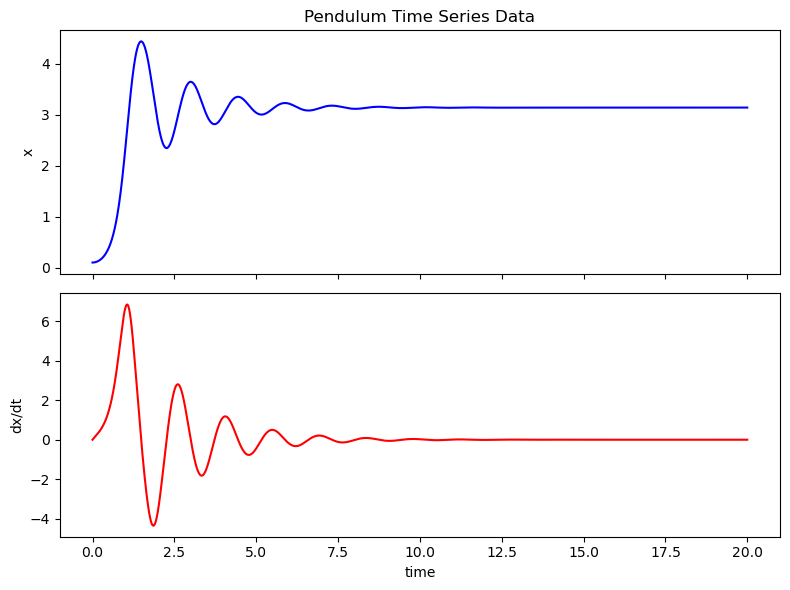

In [3]:
# ------------------------------------------------
# 3. Library Selection: Polynomials vs. Trigonometric
# ------------------------------------------------

# Pendulum system parameters and ODE
def pendulum_ode(t, x, params):
    m, l, k, g = params['m'], params['l'], params['k'], params['g']
    dxdt = x[1]
    d2xdt2 = (g/l) * np.sin(x[0]) - (k/(m*l**2)) * x[1]
    return [dxdt, d2xdt2]

    
# Generate Inverted Pendulum Data
pendulum_params = {'m': 0.1, 'l': 0.5, 'k': 0.03, 'g': 9.8}
x0_pendulum = [0.1, 0]
dt_pendulum = 0.001
t_final_pendulum = 20
t_pendulum = np.arange(0, t_final_pendulum, dt_pendulum)

sol_pendulum = solve_ivp(pendulum_ode, (0, t_final_pendulum), x0_pendulum,
                         t_eval=t_pendulum, args=(pendulum_params,), rtol=1e-12, atol=1e-12)
x_pendulum = sol_pendulum.y.T

# Add noise
sig_pendulum = 0.0
x_pendulum_noisy = x_pendulum + sig_pendulum * np.std(x_pendulum) * np.random.randn(*x_pendulum.shape)

plot_pendulum(t_pendulum, x_pendulum_noisy)

In [ ]:
# Case 1: Polynomial Library
poly_library = ps.PolynomialLibrary(degree=3)
optimizer = ps.STLSQ(threshold=0.025)
model_poly = ps.SINDy(feature_library=poly_library, optimizer=optimizer)
model_poly.fit(x_pendulum_noisy, t=dt_pendulum)

print("SINDy model (Polynomial Library):")
model_poly.print()

# Simulate and plot the polynomial model's prediction
x_poly_sim = model_poly.simulate(x0_pendulum, t=t_pendulum)
plot_sindy_pendulum(t_pendulum, x_pendulum_noisy, t_pendulum, x_poly_sim)

SINDy model (Polynomial Library):
(x0)' = 1.000 x1
(x1)' = -1.529 1 + 40.721 x0 + -4.835 x1 + -19.475 x0^2 + 2.149 x0 x1 + 0.149 x1^2 + 2.122 x0^3 + -0.311 x0^2 x1 + -0.047 x0 x1^2


In [ ]:
# Case 2: Polynomial + Trigonometric Library

# Create the polynomial library
poly_library = ps.PolynomialLibrary(degree=3)
# Create the trigonometric library -> This library includes sin(x), cos(x), sin(dx/dt), cos(dx/dt)
trig_library = ps.FourierLibrary(n_frequencies=1)
# Combine the two libraries using the '+' operator
combined_library = poly_library + trig_library

optimizer = ps.STLSQ(threshold=0.025)

model_trig = ps.SINDy(feature_library=combined_library, optimizer=optimizer)
model_trig.fit(x_pendulum_noisy, t=dt_pendulum)

print("SINDy model (Polynomial + Trig Library):")
model_trig.print()

# Simulate and plot the trigonometric model's prediction
x_trig_sim = model_trig.simulate(x0_pendulum, t=t_pendulum)
plot_sindy_pendulum(t_pendulum, x_pendulum_noisy, t_pendulum, x_trig_sim)